# <b>Importing libraries:</b>

In [1]:
!pip install transformers[torch]
!pip install accelerate -U

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 265.7/265.7 kB 1.5 MB/s eta 0:00:00


In [2]:
!pip install transformers datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 521.2/521.2 kB 3.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 7.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 13.9 MB/s eta 0:00:00


In [9]:
import numpy as np
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt

import torch

from sklearn.metrics import f1_score, accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split

# <b>Dataset:</b>

In [10]:
# https://www.kaggle.com/crowdflower/twitter-airline-sentiment
!wget -nc https://lazyprogrammer.me/course_files/AirlineTweets.csv

File ‘AirlineTweets.csv’ already there; not retrieving.



In [11]:
df_ = pd.read_csv("AirlineTweets.csv")
df_.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [12]:
#Only choosing "airline_sentiment", "text"

df = df_[["airline_sentiment", "text"]].copy()
df.head()

,airline_sentiment,text
0,neutral,@VirginAmerica What @dhepburn said.
1,positive,@VirginAmerica plus you've added commercials t...
2,neutral,@VirginAmerica I didn't today... Must mean I n...
3,negative,@VirginAmerica it's really aggressive to blast...
4,negative,@VirginAmerica and it's a really big bad thing...


In [13]:
target_map = {'positive':1, 'negative':0, 'neutral':2}
df["target"] = df['airline_sentiment'].map(target_map)
df.head()

,airline_sentiment,text,target
0,neutral,@VirginAmerica What @dhepburn said.,2
1,positive,@VirginAmerica plus you've added commercials t...,1
2,neutral,@VirginAmerica I didn't today... Must mean I n...,2
3,negative,@VirginAmerica it's really aggressive to blast...,0
4,negative,@VirginAmerica and it's a really big bad thing...,0


<Axes: >

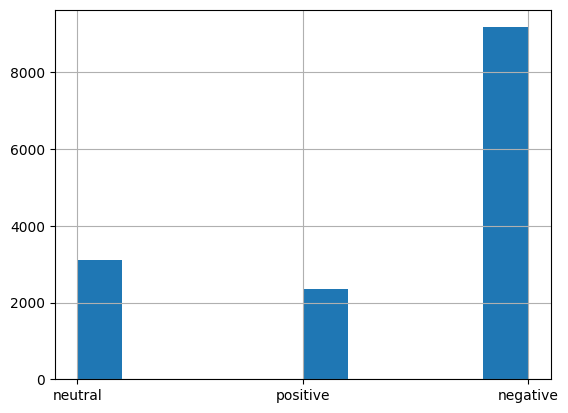

In [14]:
#Let's check if the dataset is balance (probably is not):

df['airline_sentiment'].hist()

In [15]:
#Save the data to a new csv file so that we can load it with HuggingFace next.

df2 = df[['text', 'target']]
df2.columns = ['sentence', 'label'] #renaming because 'target' column should have the name "label" in the huggingface or something like that.
df2.to_csv('data.csv', index = None)

In [16]:
!head data.csv

sentence,label
@VirginAmerica What @dhepburn said.,2
@VirginAmerica plus you've added commercials to the experience... tacky.,1
@VirginAmerica I didn't today... Must mean I need to take another trip!,2
"@VirginAmerica it's really aggressive to blast obnoxious ""entertainment"" in your guests' faces &amp; they have little recourse",0
@VirginAmerica and it's a really big bad thing about it,0
"@VirginAmerica seriously would pay $30 a flight for seats that didn't have this playing.
it's really the only bad thing about flying VA",0
"@VirginAmerica yes, nearly every time I fly VX this “ear worm” won’t go away :)",1
"@VirginAmerica Really missed a prime opportunity for Men Without Hats parody, there. https://t.co/mWpG7grEZP",2


In [17]:
#Load the data with HuggingFace

from datasets import load_dataset
raw_data = load_dataset("csv", data_files="data.csv")
raw_data

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['sentence', 'label'],
        num_rows: 14640
    })
})

#### <b> 1. Splitting for train set since it is none-existant in the dataset:</b>

In [18]:
split = raw_data['train'].train_test_split(test_size=0.3, seed=42)
split

DatasetDict({
    train: Dataset({
        features: ['sentence', 'label'],
        num_rows: 10248
    })
    test: Dataset({
        features: ['sentence', 'label'],
        num_rows: 4392
    })
})

In [13]:
# if you have multiple csv files
# load_dataset('csv', data_files=['file1.csv', 'file2.csv'])

In [14]:
# if you already have a train-test split:
# load_dataset(
#     'csv',
#     data_files={'train': ['train1.csv', 'train2.csv'],
#                 'test': 'test.csv'
#     }
# )

# <b>Tokenizer:</b>

In [15]:
from transformers import AutoTokenizer

checkpoint = 'distilbert-base-uncased' #trains faster than "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [16]:
def tokenizer_func(batch):
  return tokenizer(batch['sentence'], truncation=True) #we don't put 'pdding=True', since it will be automatically applied by the trainer

tokenized_sentences = split.map(tokenizer_func, batched=True)

Map:   0%|          | 0/10248 [00:00<?, ? examples/s]

Map:   0%|          | 0/4392 [00:00<?, ? examples/s]

# <b> Loading the Model and its parameters: </b>

In [17]:
from transformers import TrainingArguments, AutoModelForSequenceClassification, Trainer

training_args = TrainingArguments(
    output_dir='my_trainer',
    evaluation_strategy='epoch',
    save_strategy='epoch',
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=64
 )

model = AutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=3)

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.weight', 'classifier.bias', 'pre_classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


# <b> Model summary:</b>

In [18]:
type(model)

transformers.models.distilbert.modeling_distilbert.DistilBertForSequenceClassification

In [19]:
model

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
 

In [20]:
!pip install torchinfo

from torchinfo import summary
summary(model)

Layer (type:depth-idx)                                  Param #
DistilBertForSequenceClassification                     --
├─DistilBertModel: 1-1                                  --
│    └─Embeddings: 2-1                                  --
│    │    └─Embedding: 3-1                              23,440,896
│    │    └─Embedding: 3-2                              393,216
│    │    └─LayerNorm: 3-3                              1,536
│    │    └─Dropout: 3-4                                --
│    └─Transformer: 2-2                                 --
│    │    └─ModuleList: 3-5                             42,527,232
├─Linear: 1-2                                           590,592
├─Linear: 1-3                                           2,307
├─Dropout: 1-4                                          --
Total params: 66,955,779
Trainable params: 66,955,779
Non-trainable params: 0

# <b> Save the model parameters before fine-tuning:</b>

In [21]:
params_before = []
for name, p in model.named_parameters():
  params_before.append(p.detach().cpu().numpy())

# <b> Training:</b>

1. Metrics

In [22]:
def compute_metrics(logits_and_labels):
  logits, labels = logits_and_labels
  predictions = np.argmax(logits, axis=-1)
  acc = np.mean(predictions==labels)
  f1 = f1_score(labels, predictions, average='macro')
  return {'accuracy':acc, 'f1':f1}

2. Trainer:

In [23]:
from transformers import Trainer

trainer = Trainer(
    model,
    training_args,
    train_dataset=tokenized_sentences['train'],
    eval_dataset=tokenized_sentences['test'],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

trainer.train()

You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.527200,0.444426,0.829007,0.756681
2,0.325500,0.466396,0.844718,0.787713
3,0.233200,0.577287,0.847222,0.797454


TrainOutput(global_step=1923, training_loss=0.31458602841794336, metrics={'train_runtime': 10155.3169, 'train_samples_per_second': 3.027, 'train_steps_per_second': 0.189, 'total_flos': 358349332130064.0, 'train_loss': 0.31458602841794336, 'epoch': 3.0})

In [25]:
!ls

AirlineTweets.csv  data.csv  my_trainer  sample_data


In [26]:
!ls my_trainer

checkpoint-1282  checkpoint-1923  checkpoint-641  runs


# <b>Pipeline the model and apply on the test part of the dataset:</b>

In [3]:
# !pip install tensorflow==2.14
# #And then restarting the session

In [4]:
# import tensorflow
# tensorflow.__version__ #upgrading from 2.12.0 to 2.14 due to an error occurring while importing 'pipeline'

In [7]:
from transformers import pipeline

text_classifier = pipeline('text-classification',
                           model="my_trainer/checkpoint-1282"
                          ) #device=0 for GPU

In [25]:
preds = text_classifier(split['test']['sentence'])

preds[0:3] #see how the predictions look like

[{'label': 'LABEL_1', 'score': 0.9478616714477539},
 {'label': 'LABEL_1', 'score': 0.9421525597572327},
 {'label': 'LABEL_0', 'score': 0.639298677444458}]

In [26]:
def get_the_labels(i):
  return int(i['label'].split('_')[1])


preds_refined = [get_the_labels(i) for i in preds]

preds_refined[0:3]

[1, 1, 0]

accuracy: 0.8447176684881603
f1-score: 0.7877133184859261


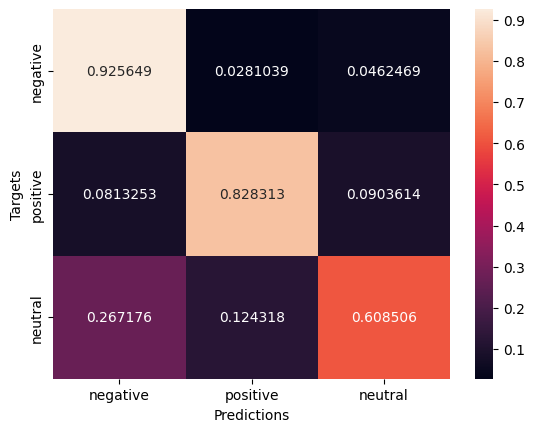

In [28]:
#calculate accuracy and f1-score

print("accuracy:", accuracy_score(split['test']['label'], preds_refined))
print("f1-score:", f1_score(split['test']['label'], preds_refined, average='macro'))

def plot_cm(cm):
  classes=['negative', 'positive', 'neutral']
  cm_data = pd.DataFrame(cm, index=classes, columns=classes)
  ax = sn.heatmap(cm_data,annot=True, fmt='g')
  ax.set_xlabel('Predictions')
  ax.set_ylabel('Targets')


cm = confusion_matrix(split['test']['label'], preds_refined, normalize='true')
plot_cm(cm)